In [1]:
# all libraries used in this notebook
import sys
import os.path
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import importlib
import platform

/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import necessary functions from the folder "05_Utilities"

cwd = str(Path.cwd()) # current working directory, should be the path to "02_Data_Augmentation", in which this notebook is located
parent_dir = str(Path(cwd).parent) # parent dir of the current working directory, should be the project directory
utilities_dir_full_pat = os.path.join(parent_dir, "05_Utilities") # full path to the "05_Utilities" folder

# import moduls
sys.path.append(utilities_dir_full_pat) # add the path to the "05_Utilities" folder to the sys.path list
from plotSpectrogram import spectrogramPlotter # modul for mel-spectrogram visualization

# make instances of the classes
spectrogramPlotter = spectrogramPlotter()

In [3]:
# sorting function for files and directories

def sort_key_func(file_name):
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

In [4]:
# import data from selected dataset

cwd = str(Path.cwd())
parent_dir = os.path.dirname(cwd)
audio_datasets_main_dir = "01_Dataset/01_audioDatasets"
audio_datasets_main_dir = os.path.join(parent_dir, audio_datasets_main_dir)

audio_datasets = []
if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets)
else:
    print("Audio dataset directory does not exist")

print(audio_datasets)

['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [5]:
# load noise samples

dataset_num_noise = 6 # noise dataset

spec_chunks_noise = None
spec_chunk_labels_noise = None

dataset_dir_noise = os.path.join(audio_datasets_main_dir, audio_datasets[dataset_num_noise])
file_list_noise = [f for f in os.listdir(dataset_dir_noise) if f.endswith('.npz')]

print(file_list_noise)
if len(file_list_noise) == 0:
    print(f"No npz file in the directory")
else:
    for file in file_list_noise:
        file_fullpath = os.path.join(dataset_dir_noise, file)
        print(file_fullpath)

        data = np.load(file_fullpath)

        if spec_chunks_noise is None:
            spec_chunks_noise = data['spec_chunks']
            spec_chunk_labels_noise = data['labels']
        else:
            spec_chunks_noise = np.concatenate((spec_chunks_noise, data['spec_chunks']), axis=0)
            spec_chunk_labels_noise = np.concatenate((spec_chunk_labels_noise, data['labels']), axis=0)


print(len(spec_chunks_noise))
print(f"positive samples: {np.count_nonzero(spec_chunk_labels_noise == 1)}")

print(np.max(spec_chunks_noise))
print(np.min(spec_chunks_noise))

['noise_dataset.npz']
/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/01_Dataset/01_audioDatasets/07_Noise_Samples/noise_dataset.npz
2364
positive samples: 0
0.0
-120.0


/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/05_Utilities/plotSpectrogram.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


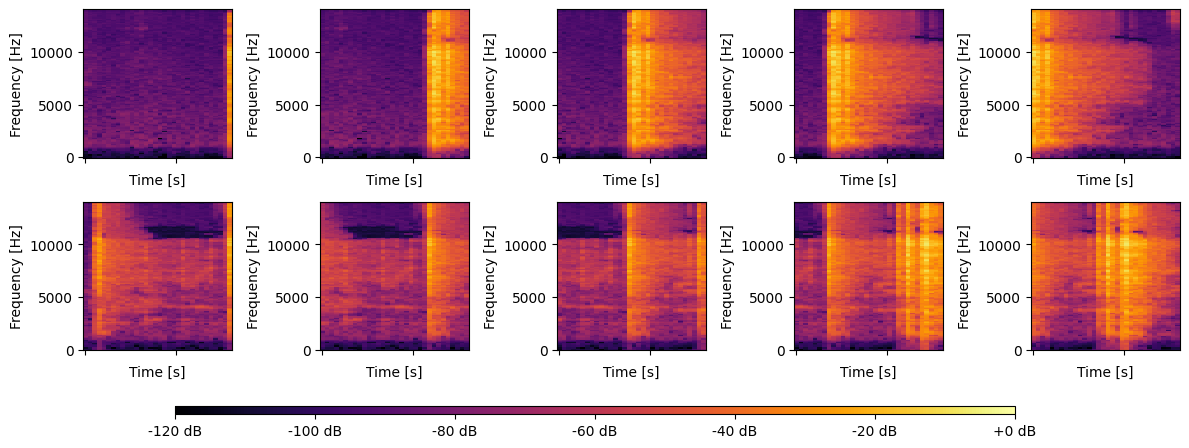

In [6]:
# plot click mel spectrograms

top_dB_abs = 120
f_min = 20
f_max = 14000
n_mels = 128

num_spectrogram_chunks = 10
num_cols = 5

spectrogramPlotter.plot_multiple_mel_spectrograms(spec_chunks_noise, top_dB_abs, f_min, f_max, n_mels, num_spectrogram_chunks, num_cols)

### Generating new samples uing VAE

In [7]:
# normalize spectrogram chunks

## update with the decibel scale min max used in real time detection!!!

def normalize_spectrogram_chunks(spec_chunks):
    # find global min and max values
    """global_min = np.min(spec_chunks)
    global_max = np.max(spec_chunks)"""

    # min and max dB values set in the preprocessing notebook
    global_min = -120
    global_max = 0

    print(global_min, global_max)

    normalized_spectrograms = [(spec - global_min) / (global_max - global_min) for spec in spec_chunks]

    return normalized_spectrograms

spec_chunks_norm = normalize_spectrogram_chunks(spec_chunks_noise)

print(spec_chunks_norm[0].shape)
print(np.min(spec_chunks_norm[0]), np.max(spec_chunks_norm[0]))

-120 0
(128, 32)
0.0 0.85488623


In [8]:
# split the dataset into training and test sets

# create a dataframe to store the spectrogram chunks and their labels
df_spectrogram_dataset = pd.DataFrame(columns=['spectrogram', 'label'])

# add the spectrogram chunks and their labels to the dataframe
df_spectrogram_dataset['spectrogram'] = spec_chunks_norm
df_spectrogram_dataset['label'] = spec_chunk_labels_noise

print(df_spectrogram_dataset.head())

# Function to split a dataframe according to the 60-20-20 ratio
def split_df(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42)  # test_size = 0.2
    return train, test

train_set, test_set = split_df(df_spectrogram_dataset)

print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}")
print(train_set.label.value_counts())
print(test_set.label.value_counts())

                                         spectrogram  label
0  [[0.048703194, 0.050411735, 0.11253325, 0.1371...      0
1  [[0.12014452, 0.06039416, 0.10784333, 0.033810...      0
2  [[0.0055634817, 0.0, 0.13975665, 0.08744373, 0...      0
3  [[0.08140843, 0.08834871, 0.051368713, 0.02786...      0
4  [[0.45117024, 0.45904973, 0.30686817, 0.371103...      0
Train set size: 1891, Test set size: 473
label
0    1891
Name: count, dtype: int64
label
0    473
Name: count, dtype: int64


In [9]:
# prepare data for model input

def prepare_data(df):
    X = np.stack(df['spectrogram'].values)  # convert spectrogram list to numpy array
    #X = np.expand_dims(X, axis=1)  # add channel dimension
    y = df['label'].values
    return X, y

X_train, y_train = prepare_data(train_set)
X_test, y_test = prepare_data(test_set)

print("train data shape:", X_train.shape)
print("train targets shape:", y_train.shape)
print("test data shape:", X_test.shape)
print("test targets shape:", y_test.shape, '\n')

# convert to torch tensors
def to_tensor(X, y):
    X = torch.from_numpy(X).type(torch.float32).unsqueeze(1) # convert to torch and add channel dimension
    y = torch.from_numpy(y).type(torch.float32)
    return X, y

X_train_tens, y_train_tens = to_tensor(X_train, y_train)
X_test_tens, y_test_tens = to_tensor(X_test, y_test)

# View the first five samples
print(X_train_tens.shape, y_train_tens.shape)
print(X_test_tens.shape, y_test_tens.shape)

train data shape: (1891, 128, 32)
train targets shape: (1891,)
test data shape: (473, 128, 32)
test targets shape: (473,) 

torch.Size([1891, 1, 128, 32]) torch.Size([1891])
torch.Size([473, 1, 128, 32]) torch.Size([473])


In [10]:
# create dataloaders for training, validation and test sets

BATCH_SIZE = 16

train_dataset = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
test_dataset = torch.utils.data.TensorDataset(X_test_tens, y_test_tens)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of train dataloader: {len(train_loader)}")
print(f"Length of test dataloader: {len(test_loader)}")

train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

Length of train dataloader: 119
Length of test dataloader: 30


(torch.Size([16, 1, 128, 32]), torch.Size([16]))

In [11]:
# check if GPU is available, if not use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_channels, z_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, 
                      out_channels=32, 
                      kernel_size=4,  # Use larger kernel to reduce dimensionality more effectively
                      stride=2,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, 
                      out_channels=64, 
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.ReLU(),
        )

        # Fully connected layers for learning mean (mu) and log variance (log_var)
        self.fc_mu = nn.Linear(128*16*4, z_dim)
        self.fc_log_var = nn.Linear(128*16*4, z_dim)

        # Decoder (Fully Connected)
        self.fc_decoder = nn.Linear(z_dim, 128*16*4)

        # Decoder (Deconvolution)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=64, 
                               kernel_size=4,
                               stride=2,
                               padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=32, 
                               kernel_size=4,
                               stride=2,
                               padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=input_channels, 
                               kernel_size=4,
                               stride=2,
                               padding=1),
            nn.Sigmoid()  # Output in [0, 1] if you normalize your spectrograms
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # Calculate standard deviation from log variance
        eps = torch.randn_like(std)  # Sample epsilon from standard normal distribution
        return mu + eps * std  # Reparameterization trick

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers

        # Latent space sampling
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        z = self.reparameterize(mu, log_var)

        # Decode
        z = self.fc_decoder(z)
        z = z.view(z.size(0), 128, 16, 4)  # Reshape to feed into ConvTranspose layers
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var


In [13]:
# instantiate the model
input_channels = 1
z_dim = 128
model = VAE(input_channels, z_dim).to(device)
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=8192, out_features=128, bias=True)
  (fc_log_var): Linear(in_features=8192, out_features=128, bias=True)
  (fc_decoder): Linear(in_features=128, out_features=8192, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [14]:
lr = 1e-3
epochs = 30

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) # KL Divergence loss

    return reconstruction_loss + KLD

optimizer = optim.Adam(model.parameters(), lr=lr)

In [15]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    train_loss = 0

    for batch, (X, _) in enumerate(train_loader):
        X = X.to(device)

        optimizer.zero_grad()

        # forward pass
        x_hat, mean, log_var = model(X)

        loss = loss_function(X, x_hat, mean, log_var)
        
        # backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Average Loss: {avg_train_loss:.4f}")

Start training VAE...
Epoch 1, Average Loss: 2719.0578
Epoch 2, Average Loss: 2643.1552
Epoch 3, Average Loss: 2634.5040
Epoch 4, Average Loss: 2626.5945
Epoch 5, Average Loss: 2620.7164
Epoch 6, Average Loss: 2617.2414
Epoch 7, Average Loss: 2611.9568
Epoch 8, Average Loss: 2607.9144
Epoch 9, Average Loss: 2604.3401
Epoch 10, Average Loss: 2602.1117
Epoch 11, Average Loss: 2600.2111
Epoch 12, Average Loss: 2598.2649
Epoch 13, Average Loss: 2597.2942
Epoch 14, Average Loss: 2596.2156
Epoch 15, Average Loss: 2595.3366
Epoch 16, Average Loss: 2594.6648
Epoch 17, Average Loss: 2593.3046
Epoch 18, Average Loss: 2593.1339
Epoch 19, Average Loss: 2592.8071
Epoch 20, Average Loss: 2591.8457
Epoch 21, Average Loss: 2591.3936
Epoch 22, Average Loss: 2591.2030
Epoch 23, Average Loss: 2590.3062
Epoch 24, Average Loss: 2590.2331
Epoch 25, Average Loss: 2589.6659
Epoch 26, Average Loss: 2589.4057
Epoch 27, Average Loss: 2589.1261
Epoch 28, Average Loss: 2588.9136
Epoch 29, Average Loss: 2588.2102
E

In [16]:
# Generate images from test dataset

model.eval()

with torch.no_grad():
    for batch, (X, _) in enumerate(train_loader):
        X = X.to(device)
        
        x_hat, _, _ = model(X)

        break

print(type(x_hat))
print(x_hat.shape)

<class 'torch.Tensor'>
torch.Size([16, 1, 128, 32])


(16, 128, 32)
(128, 32)
0.10531383 0.8912761
-112.618576 -8.524994


/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/05_Utilities/plotSpectrogram.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


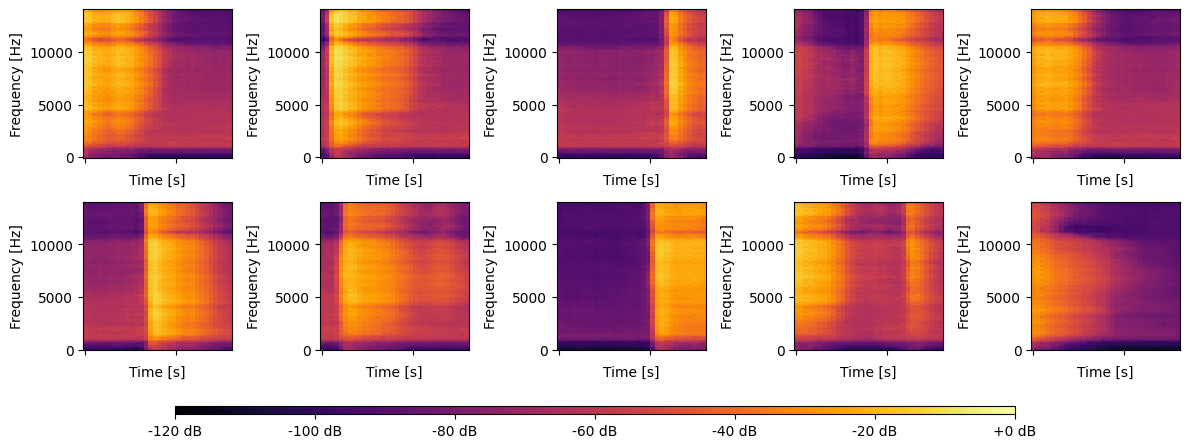

In [17]:
# print out first spectogram from x_hat

x_hat_np = x_hat.cpu().numpy().squeeze()
print(x_hat_np.shape)

spectrogram_ID_to_plot = 0

print(x_hat_np[spectrogram_ID_to_plot].shape)
print(np.min(x_hat_np[spectrogram_ID_to_plot]), np.max(x_hat_np[0]))

# denormalize the spectrogram
def denormalize_spectrogram(spec_chunk):
    global_min = -120
    global_max = 0
    return spec_chunk * (global_max - global_min) + global_min

x_hat_denorm = denormalize_spectrogram(x_hat_np)
print(np.min(x_hat_denorm), np.max(x_hat_denorm))

spectrogramPlotter.plot_multiple_mel_spectrograms(x_hat_denorm, top_dB_abs, f_min, f_max, n_mels, num_spectrogram_chunks, num_cols)

In [19]:
def generate_samples(model, num_samples):
    model.eval()

    # Sample from the standard normal distribution
    with torch.no_grad():
        z = torch.randn(num_samples, z_dim).to(device)  # Latent space has `z_dim` dimensions
        
        # Decode the latent space samples into spectrograms
        generated_spectrograms = model.decoder(model.fc_decoder(z).view(num_samples, 128, 16, 4))

    return generated_spectrograms

num_samples_to_generate = 3000
generated_samples = generate_samples(model, num_samples_to_generate)

print(generated_samples.shape)

generated_samples_np = generated_samples.cpu().numpy().squeeze()
print(generated_samples_np.shape)

generated_samples_denorm = denormalize_spectrogram(generated_samples_np)

torch.Size([3000, 1, 128, 32])
(3000, 128, 32)


/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/05_Utilities/plotSpectrogram.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


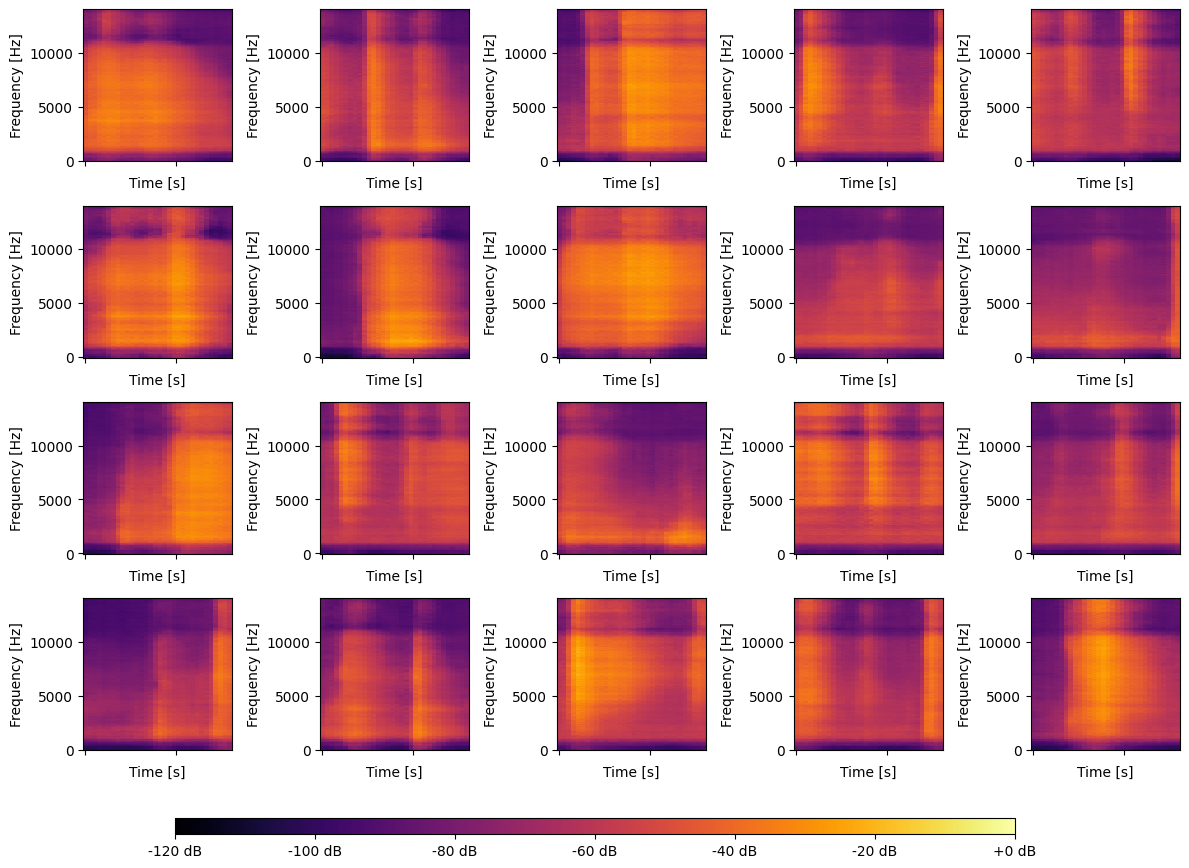

In [20]:
num_generated_samples_to_plot = 20

spectrogramPlotter.plot_multiple_mel_spectrograms(generated_samples_denorm, top_dB_abs, f_min, f_max, n_mels, num_generated_samples_to_plot, num_cols)

In [21]:
# create label array with the length of the generated samples

generated_noise_spectrogram_labels = np.ones(len(generated_samples_denorm))

print(len(generated_noise_spectrogram_labels))
print(np.count_nonzero(generated_noise_spectrogram_labels == 1))

3000
3000


In [22]:
# save the generated spectrogram dataset and labels in .npz format into the same directory as the audio files

cwd = str(Path.cwd())
save_directory = "01_generated_datasets"
filename = "noise_dataset_generated.npz"
file_fullpath = os.path.join(cwd, save_directory, filename)

spec_chunk_dataset = np.array(generated_samples_denorm)
spec_chunk_labels = np.array(generated_noise_spectrogram_labels)

#print(np.min(spec_chunk_dataset), np.max(spec_chunk_dataset))

np.savez(file_fullpath, spec_chunks=spec_chunk_dataset, labels=spec_chunk_labels)
